In [1]:
import sys
sys.path.append('/storage/vbutoi/projects')
sys.path.append('/storage/vbutoi/libraries')
sys.path.append('/storage/vbutoi/projects/ESE')
sys.path.append('/storage/vbutoi/projects/UniverSeg')

from ionpy.analysis import ResultsLoader
from ese.experiment.experiment import CalibrationExperiment
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("darkgrid")

import os 
os.environ['DATAPATH'] = ':'.join((
       '/storage/vbutoi/datasets',
))

# Results loader object does everything
rs = ResultsLoader()
root = "/storage/vbutoi/scratch/ESE"

%load_ext yamlmagic
%load_ext autoreload
%autoreload 2

In [2]:
path = f"{root}/WMH_aug_runs"

dfc = rs.load_configs(
    path,
    properties=False,
)

df = rs.load_metrics(dfc)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [3]:

os.environ["CUDA_VISIBLE_DEVICES"] = '1'

best_exp = rs.get_best_experiment(
    df=df,
    exp_class=CalibrationExperiment,
    device="cuda"
)
best_exp.build_dataloader()

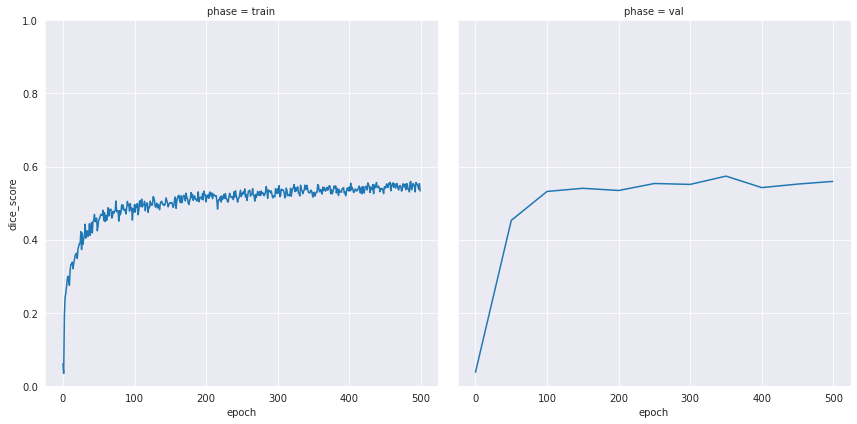

In [4]:
best_exp.vis_loss_curves(height=6)

In [5]:
from ese.experiment.analysis.inference import get_dataset_perf 

# val_perf is a dict where each item is the subj id
predictions_list = get_dataset_perf(
    exp=best_exp, 
    split="val"
    )

  0%|          | 0/15 [00:00<?, ?it/s]

In [6]:
from ese.experiment.analysis.inference import get_pixelinfo_df

pixel_preds_df = get_pixelinfo_df(
    data_points=predictions_list,
    num_bins=10,
    num_labels=2
    )

  0%|          | 0/15 [00:00<?, ?it/s]

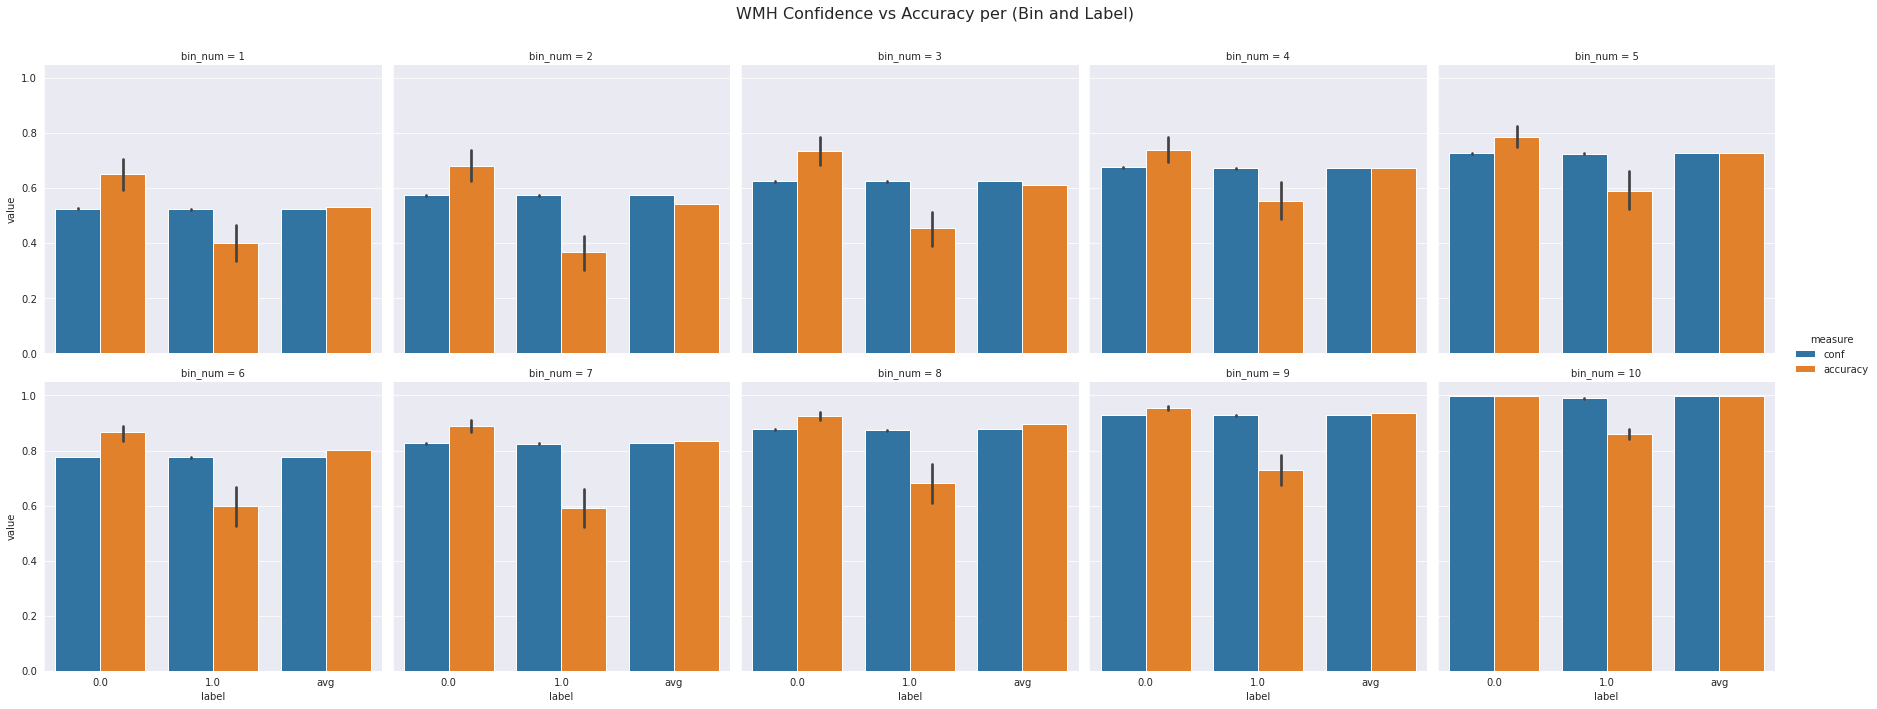

In [7]:
from ese.experiment.analysis.err_diagrams import viz_accuracy_vs_confidence

viz_accuracy_vs_confidence(
    pixel_preds_df,
    per_bin=True,
    x="label",
    hue="measure",
    title="WMH Confidence vs Accuracy per (Bin and Label)"
    )

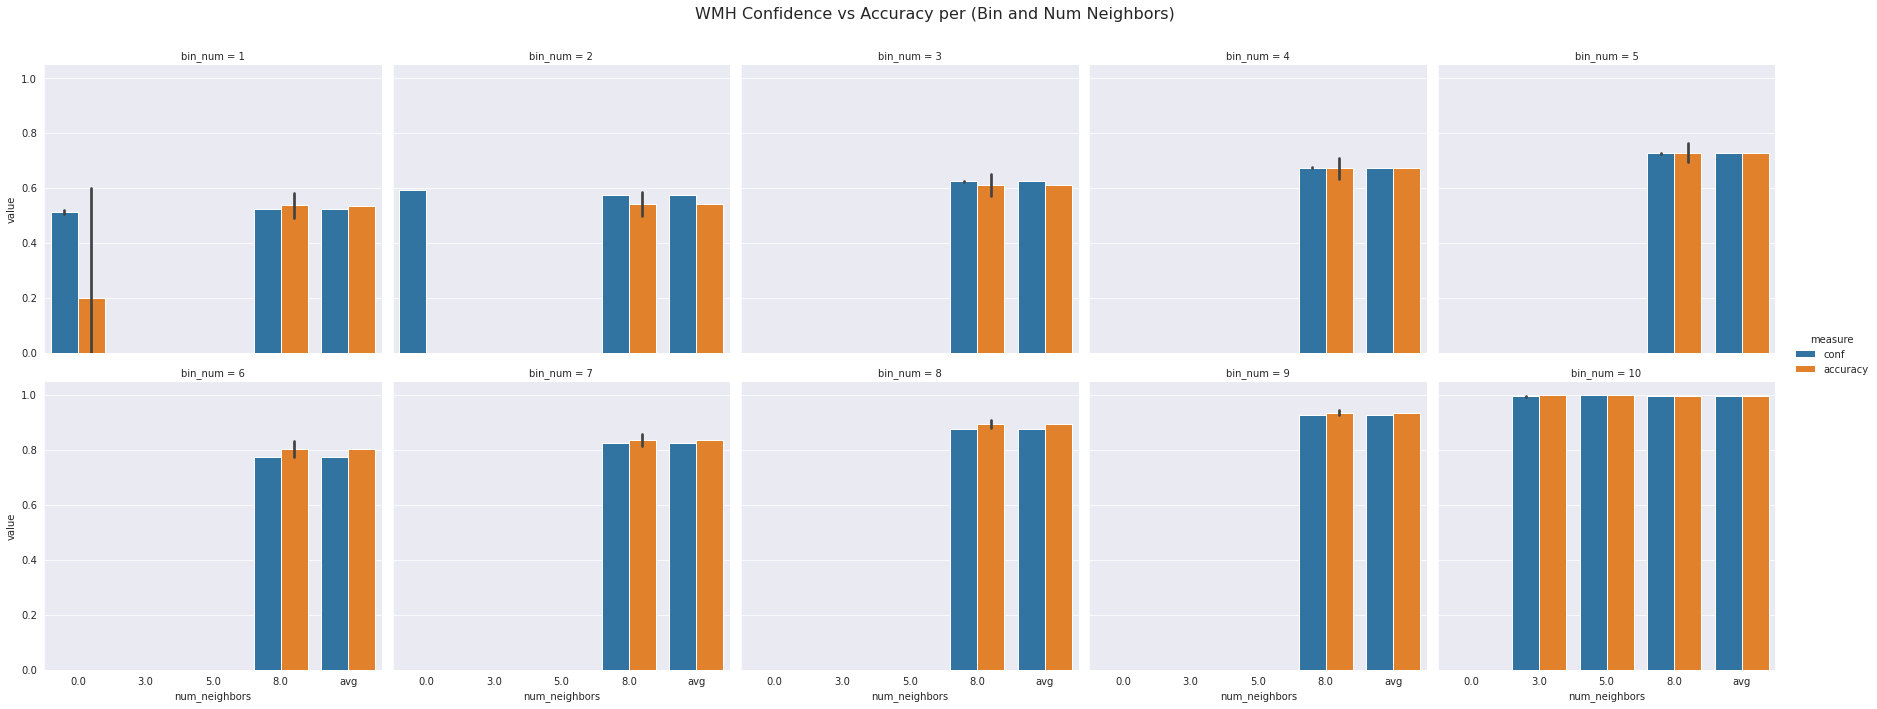

In [8]:
from ese.experiment.analysis.err_diagrams import viz_accuracy_vs_confidence

viz_accuracy_vs_confidence(
    pixel_preds_df,
    per_bin=True,
    x="num_neighbors",
    hue="measure",
    title="WMH Confidence vs Accuracy per (Bin and Num Neighbors)"
    )

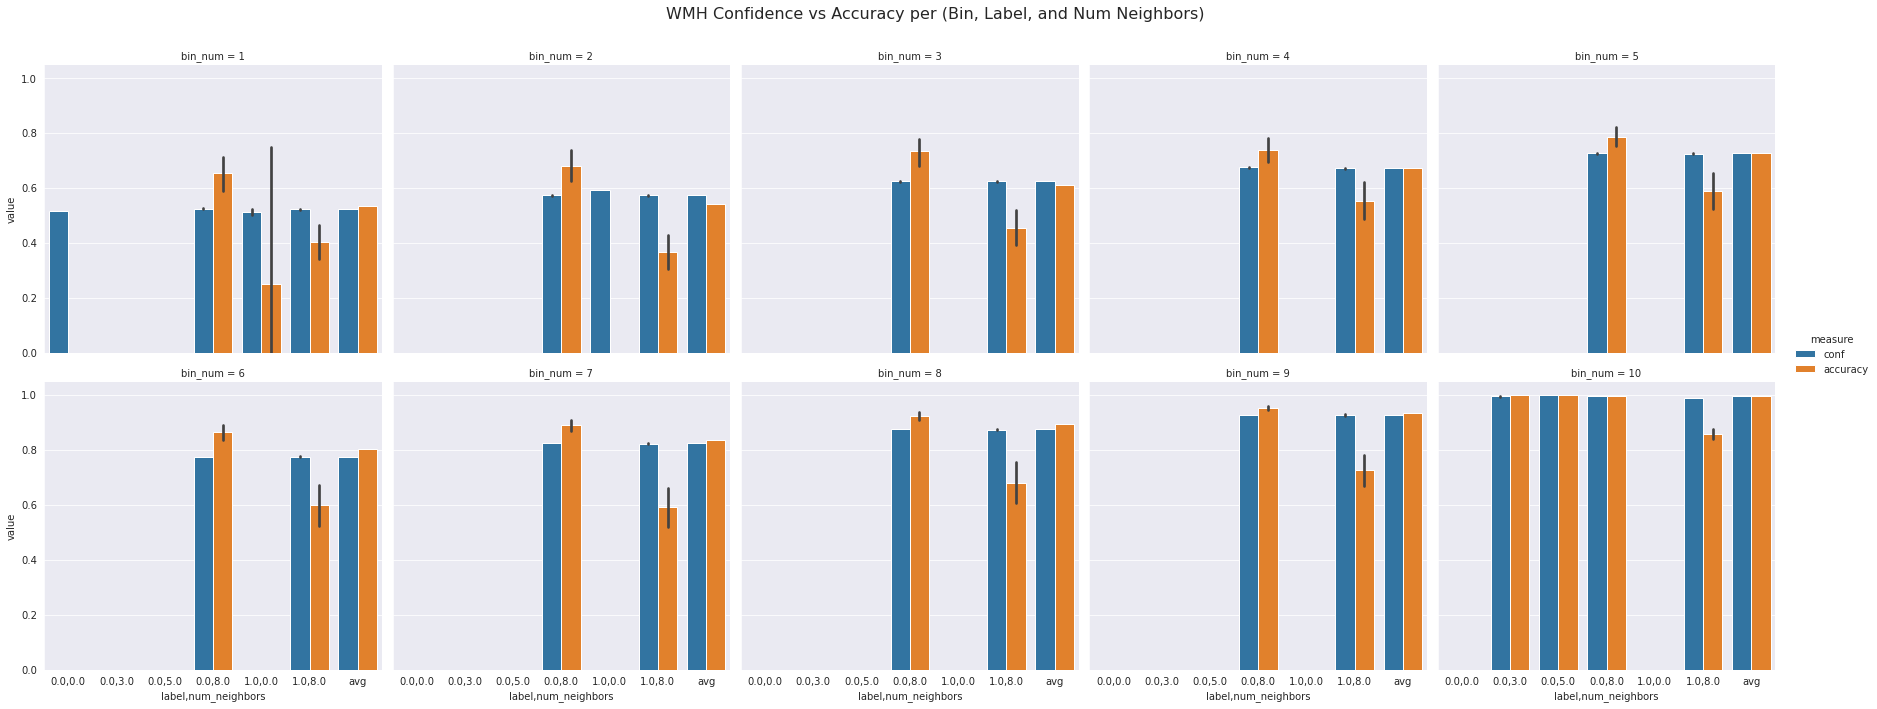

In [9]:
from ese.experiment.analysis.err_diagrams import viz_accuracy_vs_confidence

viz_accuracy_vs_confidence(
    pixel_preds_df,
    per_bin=True,
    x="label,num_neighbors",
    hue="measure",
    title="WMH Confidence vs Accuracy per (Bin, Label, and Num Neighbors)"
    )